![](https://simplonline.co/_next/image?url=https%3A%2F%2Fsimplonline-v3-prod.s3.eu-west-3.amazonaws.com%2Fmedia%2Fimage%2Fjpg%2Fcb4b9733-3fff-43d0-a1c7-e469e016b978.jpg&w=1280&q=75)

# Segmentation des lésions pulmonaires

Ce brief a pour objectif de manipuler une architecture CNN pour réaliser la segmentation.

Dans ce brief, nous appliquons un apprentissage supervisé pour détecter les lésions pulmonaires à partir d’une image.


In [1]:
!git clone https://github.com/Rom1deTroyes/Segmentation_Lesions_Pulmonaires  # clone
%cd Segmentation_Lesions_Pulmonaires
#%pip install -qr requirements.txt  # install

fatal: destination path 'Segmentation_Lesions_Pulmonaires' already exists and is not an empty directory.
/content/Segmentation_Lesions_Pulmonaires


In [2]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import cv2
import os
import random

from tqdm.notebook import tqdm

import numpy as np

## Partie 1 : Base de données

### Charger les images.


#### **Redimensionner** les images selon le modèle souhaité.

In [4]:
width=240
height=240

In [5]:
dir_img="frames/"
dir_mask="masks/"

tab_img=[]
tab_mask=[]

# Récupération de la liste des fichiers images
files = os.listdir(dir_img)
# Mélange des images 
random.Random(42).shuffle(files)

for n, i in tqdm(enumerate(files), total=len(files)):

    tab_img.append(cv2.resize(cv2.imread(dir_img+i), (width, height))/255)

    img_mask=cv2.resize(cv2.imread(dir_mask+i), (width, height))[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 1), dtype=np.float32)
    img_mask_result[:,:,0][img_mask==255]=1.
    tab_mask.append(img_mask_result)

tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)

  0%|          | 0/2729 [00:00<?, ?it/s]

In [6]:
print(tab_img.shape)
print(tab_mask.shape)

(2729, 240, 240, 3)
(2729, 240, 240, 1)


#### Séparation des données en données d’apprentissage, validation et test.

In [7]:
val_num = 15/100
test_num = 20/100


In [8]:
val_split = int(1 - val_num * len(tab_img))

test_split = int(1 - test_num * (len(tab_img) - val_split))

print(val_split, test_split)

#split into training and testing
x_train = tab_img[0:test_split]
y_train = tab_mask[0:test_split]

x_test = tab_img[test_split:val_split]
y_test = tab_mask[test_split:val_split]

x_valid = tab_img[val_split:]
y_valid = tab_mask[val_split:]


print(x_train.shape, x_test.shape, x_valid.shape)
print(y_train.shape, y_test.shape, y_valid.shape)


-408 -626
(2103, 240, 240, 3) (218, 240, 240, 3) (408, 240, 240, 3)
(2103, 240, 240, 1) (218, 240, 240, 1) (408, 240, 240, 1)


#### Visualiser les images de CT et sa vérité terrain (segmentation manuelle).

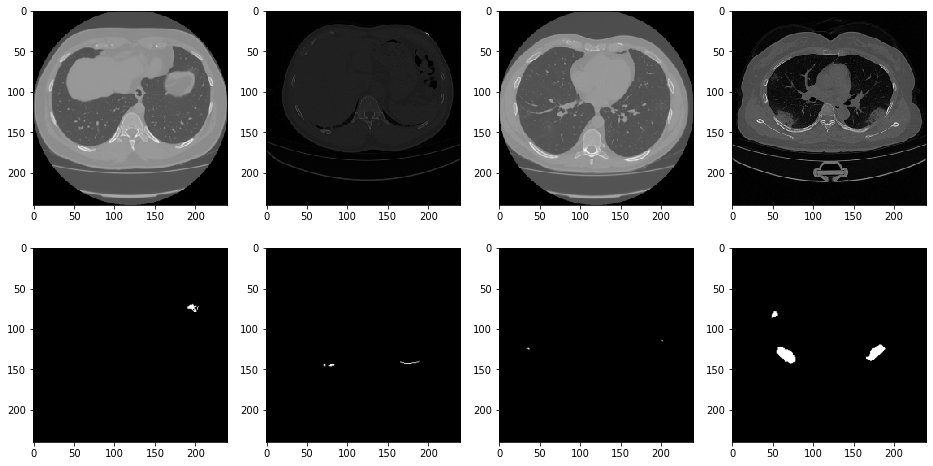

In [9]:
from matplotlib import pyplot as plt

n = 4
h = 4
f, axarr = plt.subplots(2,n, figsize=(h*n,2*h))

for c in range(n):
  r = c * int(len(tab_img)/(n-1))
  axarr[0,c].imshow(tab_img[r], interpolation='nearest')
  axarr[1,c].imshow(tab_mask[r,:,:,0], cmap='gray')


#plt.imshow(tab_img[42], interpolation='nearest')
#plt.show()

#plt.imshow(tab_mask[42,:,:,0], cmap='gray')
#plt.show()

- [ ] Appliquer la data augmentation.


## Partie 2 : Transfer Learning

- Préparation du modèle de segmentation

- Aapplication d'un Transfer Learning sur l'architecture.

- F1-Score sur la base de test.


## Test

Affichage de l'image détourée par son masque

In [ ]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()